Loading and preprocessing data...
Data loaded successfully!
Initial data shape: (14383, 16)

First few rows of raw data:

Combining all derived features...

Creating age feature...

Creating distance feature...

Creating time-based features...

Creating location-based features...


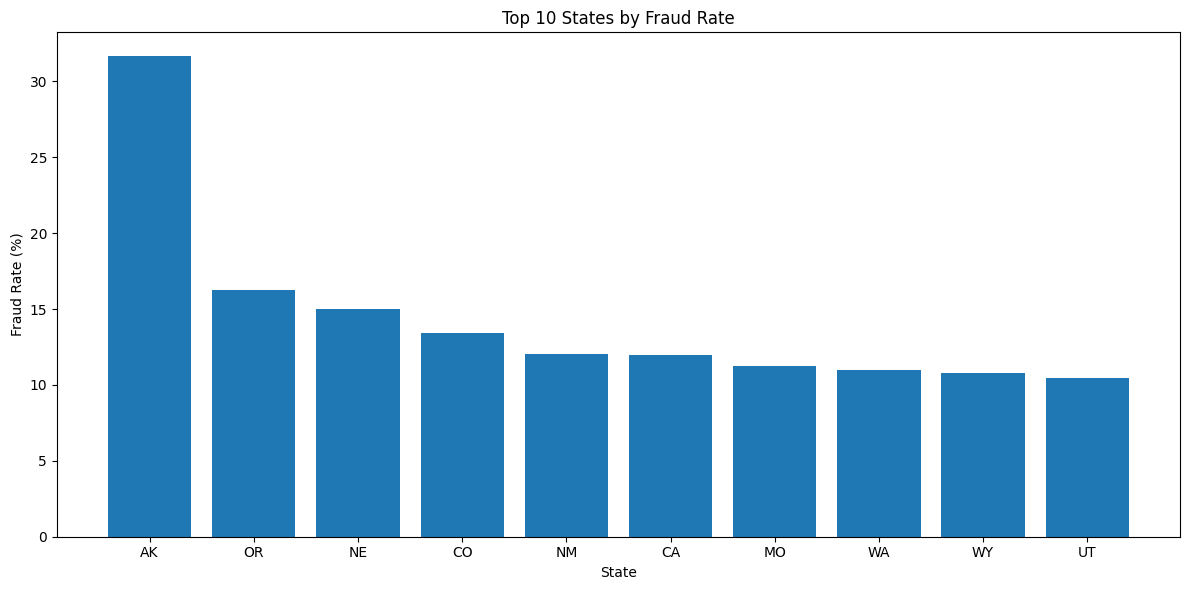


Added 11 new features:
  - Unnamed: 0
  - age
  - distance_km
  - trans_hour
  - trans_dayofweek
  - trans_month
  - trans_day
  - is_weekend
  - time_period
  - city_pop_bin
  - high_risk_state
Preprocessed data shape: (14383, 26)

First few rows of preprocessed data:
   Unnamed: 0 trans_date_trans_time                          merchant  \
0           0      04-01-2019 00:58  "Stokes, Christiansen and Sipes"   
1           1      04-01-2019 15:06                      Predovic Inc   
2           2      04-01-2019 22:37                   Wisozk and Sons   
3           3      04-01-2019 23:06                    Murray-Smitham   
4           4      04-01-2019 23:59                        Friesen Lt   

         category     amt   city state      lat      long  city_pop  ...  \
0     grocery_net   14.37  Wales    AK  64.7556 -165.6723       145  ...   
1    shopping_net  966.11  Wales    AK  64.7556 -165.6723       145  ...   
2        misc_pos   49.61  Wales    AK  64.7556 -165.6723     

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
import datetime
from math import *

# Define Sigmoid Function
def sigmoid(z):
    """
    Compute the sigmoid of z (works for both arrays and scalar values)
    """
    return 1 / (1 + np.exp(-np.array(z, dtype=float)))

# Define Cost Function (keeping your original function)
def compute_cost_logistic(y, y_hat):
    m = len(y) # Number of training examples
    epsilon = 1e-5 # Small constant to prevent log being 0
    # Compute the logistic regression cost
    cost = (-1 / m) * (y.T.dot(np.log(y_hat + epsilon)) + (1 - y).T.dot(np.log(1 - y_hat + epsilon)))
    return cost

# Optimization function (keeping your original function)
def optimize_theta(theta, X, y):
    # Define the objective function to minimize
    def objective_function(t):
        # Calculate the predicted probabilities (y_hat)
        y_hat = sigmoid(X.dot(t))
        # Compute the cost with current theta, y, and y_hat
        return compute_cost_logistic(y, y_hat)
    
    # Run the optimizer with the objective function
    result = minimize(objective_function, theta, method='TNC', jac=False)
    return result.x, result.fun

def load_data(file_path):
    """
    Load the fraud detection dataset.
    
    Parameters:
    -----------
    file_path : str
        Path to the dataset CSV file
    
    Returns:
    --------
    df : DataFrame
        The loaded dataset
    """
    print("Loading data...")
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Display basic information
    print(f"Dataset shape: {df.shape}")
    
    return df

def create_age_feature(df):
    """
    Create customer age feature from date of birth (dob).
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with 'dob' column
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added age feature
    """
    print("\nCreating age feature...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Convert DOB to datetime
    df['dob'] = pd.to_datetime(df['dob'], format='%m-%d-%Y', errors='coerce')
    
    # Extract transaction date from transaction datetime
    # First convert the transaction date to datetime
    df['trans_date'] = pd.to_datetime(df['trans_date_trans_time'], format='%m-%d-%Y %H:%M', errors='coerce')
    
    # Calculate age at time of transaction
    # If transaction date is not available, use a reference date (e.g., 2019-01-01)
    ref_date = pd.to_datetime('2019-01-01')  # Assuming all transactions are around 2019
    
    # For transactions with valid dates, use those dates
    df['age'] = np.where(
        df['trans_date'].notna(),
        (df['trans_date'] - df['dob']).dt.days / 365.25,
        (ref_date - df['dob']).dt.days / 365.25
    )
    
    # Handle any anomalies (negative ages, extremely high ages)
    df['age'] = df['age'].clip(lower=18, upper=100)  # Assuming customers are between 18 and 100
    
    return df

def create_distance_feature(df):
    """
    Calculate distance between customer location and merchant location.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with lat, long, merch_lat, merch_long columns
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added distance feature
    """
    print("\nCreating distance feature...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Haversine formula to calculate distance between two points on the Earth
    def haversine_distance(lat1, lon1, lat2, lon2):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # Haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371  # Radius of earth in kilometers
        return c * r
    
    # Apply the haversine function to calculate distance
    df['distance_km'] = df.apply(
        lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long'])
        if pd.notna(row['lat']) and pd.notna(row['long']) and pd.notna(row['merch_lat']) and pd.notna(row['merch_long'])
        else np.nan, 
        axis=1
    )
    
    return df

def create_time_features(df):
    """
    Extract time-based features from transaction datetime.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with 'trans_date_trans_time' column
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added time-based features
    """
    print("\nCreating time-based features...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Convert transaction datetime to proper datetime object
    df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'], format='%m-%d-%Y %H:%M', errors='coerce')
    
    # Extract various time components
    df['trans_hour'] = df['trans_datetime'].dt.hour
    df['trans_dayofweek'] = df['trans_datetime'].dt.dayofweek  # Monday=0, Sunday=6
    df['trans_month'] = df['trans_datetime'].dt.month
    df['trans_day'] = df['trans_datetime'].dt.day
    
    # Create weekend flag (0=weekday, 1=weekend)
    df['is_weekend'] = (df['trans_dayofweek'] >= 5).astype(int)
    
    # Define time of day periods
    df['time_period'] = pd.cut(
        df['trans_hour'], 
        bins=[0, 6, 12, 18, 24], 
        labels=['night', 'morning', 'afternoon', 'evening'],
        include_lowest=True
    )
    
    
    return df

def create_location_features(df):
    """
    Create features based on location data.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with location columns
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added location-based features
    """
    print("\nCreating location-based features...")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Create city population bins
    df['city_pop_bin'] = pd.cut(
        df['city_pop'], 
        bins=[0, 1000, 10000, 100000, 1000000, float('inf')],
        labels=['very_small', 'small', 'medium', 'large', 'very_large']
    )
    
    # Analyze high-risk states (if state column is available)
    if 'state' in df.columns:
        # Get states with at least 100 transactions
        state_counts = df['state'].value_counts()
        valid_states = state_counts[state_counts >= 100].index
        
        # Calculate fraud rate by state for valid states
        state_fraud = df[df['state'].isin(valid_states)].groupby('state')['is_fraud'].mean() * 100
        state_fraud = state_fraud.sort_values(ascending=False)
        
        # Plot top 10 states by fraud rate
        plt.figure(figsize=(12, 6))
        plt.bar(state_fraud.index[:10], state_fraud.values[:10])
        plt.title('Top 10 States by Fraud Rate')
        plt.xlabel('State')
        plt.ylabel('Fraud Rate (%)')
        plt.tight_layout()
        plt.show()
        
        # Create high-risk state flag
        high_risk_states = state_fraud[state_fraud > 15].index.tolist()  # States with >15% fraud rate
        df['high_risk_state'] = df['state'].isin(high_risk_states).astype(int)
    
    return df

def combine_all_features(df):
    """
    Apply all feature engineering steps and create a final dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe
    
    Returns:
    --------
    df_final : DataFrame
        Final dataframe with all derived features
    """
    print("\nCombining all derived features...")
    
    # Apply each feature engineering function
    df = create_age_feature(df)
    df = create_distance_feature(df)
    df = create_time_features(df)
    df = create_location_features(df)
    
    # Remove intermediate columns
    cols_to_drop = ['trans_datetime', 'trans_date']
    df_final = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)
    
    # List all new features
    original_cols = set(['', 'trans_date_trans_time', 'merchant', 'category', 'amt', 
                         'city', 'state', 'lat', 'long', 'city_pop', 'job', 'dob', 
                         'trans_num', 'merch_lat', 'merch_long', 'is_fraud'])
    new_cols = [col for col in df_final.columns if col not in original_cols]
    
    print(f"\nAdded {len(new_cols)} new features:")
    for col in new_cols:
        print(f"  - {col}")
    
    # Return the final dataframe
    return df_final



# Function to compute evaluation metrics
def evaluate_model(y_true, y_pred, y_prob=None):
    """
    Compute and print evaluation metrics
    """
    # Accuracy
    accuracy = np.mean(y_pred == y_true)
    
    # Create confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")
    
    # If probabilities are provided, compute ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")
        
        # Return values for plotting
        return accuracy, precision, recall, f1, roc_auc, fpr, tpr
    
    return accuracy, precision, recall, f1, None, None, None



# Load and explore the data
print("Loading and preprocessing data...")

# Read in and process Data
csv_name = input("Enter the name of the dataset: ") # Dataset needs to be in local directory
df = pd.read_csv(csv_name)
print("Data loaded successfully!")


# Print initial info
print(f"Initial data shape: {df.shape}")
print("\nFirst few rows of raw data:")

df = combine_all_features(df)

# Remove unnecessary columns
#drop_cols = ['trans_date_trans_time', 'trans_num', 'dob']
#df = df.drop(columns=drop_cols)

# Print preprocessed data info
print(f"Preprocessed data shape: {df.shape}")
print("\nFirst few rows of preprocessed data:")
print(df.head())



In [ ]:
from sklearn.pipeline import Pipeline

# Load the sklearn selector doing both "Forward" and "Backword" selections
from sklearn.feature_selection import SequentialFeatureSelector 


# Data splitting
print("\nSplitting data into training and testing sets...")
# Check for and handle any missing values before splitting
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in the dataset:")
    print(missing_values[missing_values > 0])
    
    
    print("Missing values have been handled.")
    
# Split data into features and target variable
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8)

# Display the number of samples in each set
print(f"Number of samples in Training Set : {np.size(X_train)}\n")
print(f"Number of samples in Testing Set : {np.size(X_test)}\n")





# Transform Training and Testing data
# Simple preprocessing: handle categorical features and scale numerical features
# Identify categorical and numerical columns
categorical_columns = ['merchant', 'category', 'city', 'state', 'job']
numerical_columns = [col for col in X.columns if col not in categorical_columns]




# Declare a model:
model = LogisticRegression()

# Construct the Pipeline with scaler, feature_selection technique, and model fitting
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", SequentialFeatureSelector(model, direction = "forward", n_features_to_select = 3)),
    ("model", model)
])

# Perform feature selection and obtain selected features for model fitting and testing:
# Remember that for logistic regression, since it uses GD, we need to standardize the features for faster convergence.
X_train_scaled_selected = pipe.fit(X_train, y_train) 

# Train the model with selected features:
model.fit(X_train_scaled_selected, y_train)


# Initialize theta
print("\nInitializing theta and running optimization...")
initial_theta = np.zeros(X_train_array.shape[1])


# Compute Z-Values with initial theta
z_values = np.dot(X_train_array, initial_theta)

# Calculate y_hat using the initial theta values for the training set
y_hat_train = sigmoid(z_values)  

# Compute the cost to two decimal places
cost_logistic_train = np.round(compute_cost_logistic(y_train.values, y_hat_train), 2)

# Print the computed cost for the training set
print(f"Initial cost (logistic) with zeros for theta: {cost_logistic_train}")

# Now run the optimization to find the best theta
print("\nOptimizing theta parameters...")
theta_optimized, cost_optimized = optimize_theta(initial_theta, X_train_array, y_train.values)



Splitting data into training and testing sets...

Missing values in the dataset:
dob                 9793
age                 9793
trans_hour         10050
trans_dayofweek    10050
trans_month        10050
trans_day          10050
time_period        10050
dtype: int64


C:\Users\Dylan Woods\AppData\Local\Temp\ipykernel_11240\2555954249.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\Dylan Woods\AppData\Local\Temp\ipykernel_11240\2555954249.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

TypeError: 'Categorical' with dtype category does not support reduction 'median'

In [ ]:
# Make predictions with optimized theta
print("\nMaking predictions with optimized theta...")
y_train_pred, y_train_prob = predict(X_train_array, theta_optimized)
y_test_pred, y_test_prob = predict(X_test_array, theta_optimized)

In [ ]:
#Hyper-Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Set up the hyperparameter grid (for Decision Tree)
param_grid = {
    'max_depth': [1,2,3,4,5,6,7],
    'criterion': ["gini", "entropy"]
}

# Initialize the decision tree model
model = DecisionTreeClassifier(random_state = RANDOM_STATE)

# Set up GridSearchCV
grid_search = grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = "accuracy")

# Perform the grid search (cross-validation) on the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_model =  grid_search.best_estimator_        # Obtain the best model from GridSearchCV tunning
best_accuracy_test = best_model.score(X_test_scaled, y_test) # Evaluate the best model and report test set accuracy 



print(f"Test accuracy: {best_accuracy_test: .3f}")


